# Dead reckoning- Extended Kalman, Mahony, Madgwick with equal sampling rate and smoothed signals

This notebook is an extension of the notebook "Dead-reckoning- Extended Kalman, Mahony, Madgwick". An equal sampling rate and smoothing the filter signals are introduced as additonal methods. However, no noticable improvement of the end result are visible.

In [1]:
import numpy as np
import pandas as pd

import scipy.signal

from numba import jit

from ahrs.common.orientation import acc2q

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [2]:
path = "./data/test_imu_B_2_1.csv"
imu_df = pd.read_csv(path)
imu_df.head(1)

,host_timestamp,arduino_timestamp,ax,ay,az,gx,gy,gz,temperature
0,35752794502900,440160,-9.7878,-0.1089,-0.5791,-0.1393,-0.1087,-0.0831,23.22


In [3]:
n = len(imu_df)
t = imu_df["arduino_timestamp"].values * 1e-3
a_s = imu_df[["ax", "ay", "az"]].values
g_s = imu_df[["gx", "gy", "gz"]].values

In [4]:
t


array([440.16 , 440.171, 440.183, ..., 489.306, 489.317, 489.328])

#### create equal sampling rate

In [5]:
# Calculate the average time difference
average_time_difference = int((imu_df['arduino_timestamp'].iloc[-1] - imu_df['arduino_timestamp'].iloc[0]) / len(imu_df))

# Create a new DataFrame with equal time intervals
new_time_column = pd.Series(range(imu_df['arduino_timestamp'].iloc[0], imu_df['arduino_timestamp'].iloc[-1], int(average_time_difference)))
new_df = pd.DataFrame({'arduino_timestamp': new_time_column})

# Merge the original DataFrame with the new DataFrame based on the time column
df = pd.merge_asof(new_df, imu_df, on='arduino_timestamp')

# Interpolate the missing values
df = df.interpolate()

# Reset the index if needed
imu_df = df.reset_index(drop=True)
imu_df.head(2)

,arduino_timestamp,host_timestamp,ax,ay,az,gx,gy,gz,temperature
0,440160,35752794502900,-9.7878,-0.1089,-0.5791,-0.1393,-0.1087,-0.0831,23.22
1,440171,35752805800900,-9.7998,-0.0945,-0.5862,-0.1051,-0.1136,-0.0623,23.23


#### smooth acceleration signal 

In [6]:
window_size = 10  # Adjust the window size as needed

# Extract individual axes from acceleration and gyroscope data
ax = a_s[:, 0]
ay = a_s[:, 1]
az = a_s[:, 2]

# Smooth acceleration signals using moving average
smoothed_ax = scipy.ndimage.filters.uniform_filter1d(ax, size=window_size, axis=0, mode='nearest')
smoothed_ay = scipy.ndimage.filters.uniform_filter1d(ay, size=window_size, axis=0, mode='nearest')
smoothed_az = scipy.ndimage.filters.uniform_filter1d(az, size=window_size, axis=0, mode='nearest')


a_s_smoothed = np.column_stack((smoothed_ax, smoothed_ay, smoothed_az))

C:\Users\ann-k\AppData\Local\Temp\ipykernel_18088\4124811172.py:9: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smoothed_ax = scipy.ndimage.filters.uniform_filter1d(ax, size=window_size, axis=0, mode='nearest')
C:\Users\ann-k\AppData\Local\Temp\ipykernel_18088\4124811172.py:10: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smoothed_ay = scipy.ndimage.filters.uniform_filter1d(ay, size=window_size, axis=0, mode='nearest')
C:\Users\ann-k\AppData\Local\Temp\ipykernel_18088\4124811172.py:11: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smoothed_az = scipy.ndimage.filters.uniform_filter1d(az, size=window_size, axis=0, mode='nearest')


#### filter acceleration signal

In [7]:
from scipy.signal import butter, filtfilt

# Define the cutoff frequency and filter order
cutoff_freq = 1  
filter_order = 6  

# Compute the normalized cutoff frequency
sample_rate = 1.0 / np.mean(np.diff(t))
normalized_cutoff = cutoff_freq / (0.5 * sample_rate)

# Define the Butterworth filter coefficients
b, a = butter(filter_order, normalized_cutoff, btype='low', analog=False, output='ba')

# Apply the Butterworth filter to the acceleration signals
filtered_ax = filtfilt(b, a, ax)
filtered_ay = filtfilt(b, a, ay)
filtered_az = filtfilt(b, a, az)

# Stack the filtered signals back into a_s_filtered
a_s_filtered = np.column_stack((filtered_ax, filtered_ay, filtered_az))

#### compare raw- smoothing- filtering

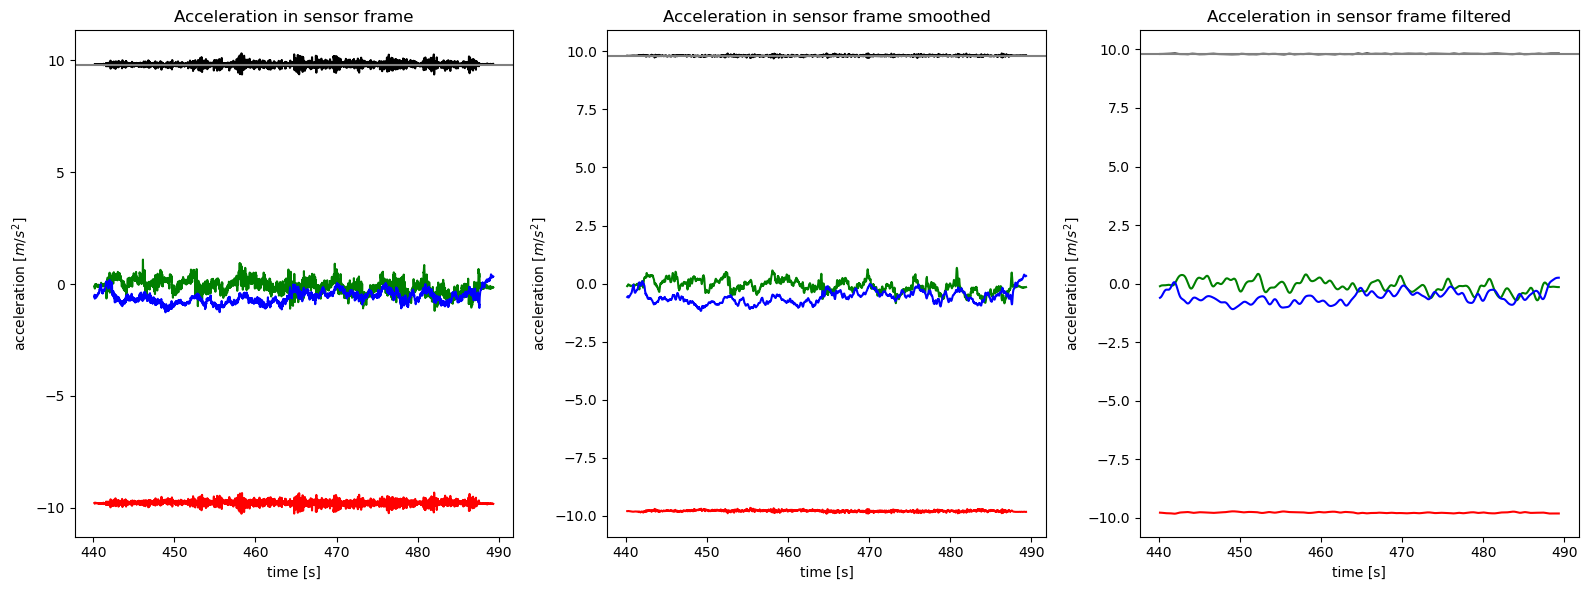

In [8]:
_, axes = plt.subplots(1, 3, figsize=(16, 6))

# Plot 1
axes[0].plot(t, a_s[:, 0], c="r")
axes[0].plot(t, a_s[:, 1], c="g")
axes[0].plot(t, a_s[:, 2], c="b")
axes[0].plot(t, np.sqrt((a_s ** 2).sum(axis=-1)), c="k")
axes[0].axhline(9.81, c="gray")
axes[0].set_xlabel("time [s]")
axes[0].set_ylabel("acceleration $[m/s^2]$")
axes[0].set_title("Acceleration in sensor frame")

# Plot 2
axes[1].plot(t, a_s_smoothed[:, 0], c="r")
axes[1].plot(t, a_s_smoothed[:, 1], c="g")
axes[1].plot(t, a_s_smoothed[:, 2], c="b")
axes[1].plot(t, np.sqrt((a_s_smoothed ** 2).sum(axis=-1)), c="k")
axes[1].axhline(9.81, c="gray")
axes[1].set_xlabel("time [s]")
axes[1].set_ylabel("acceleration $[m/s^2]$")
axes[1].set_title("Acceleration in sensor frame smoothed")

# Plot 3 
axes[2].plot(t, a_s_filtered[:, 0], c="r")
axes[2].plot(t, a_s_filtered[:, 1], c="g")
axes[2].plot(t, a_s_filtered[:, 2], c="b")
axes[2].plot(t, np.sqrt((a_s_filtered ** 2).sum(axis=-1)), c="k")
axes[2].axhline(9.81, c="gray")
axes[2].set_xlabel("time [s]")
axes[2].set_ylabel("acceleration $[m/s^2]$")
axes[2].set_title("Acceleration in sensor frame filtered")

plt.tight_layout()
plt.show()

In [9]:
# use smoothed one, change to raw (just a_s) or to filtered signal (a_s_filtered)
a_s = a_s_smoothed

#### smooth gyroscope data

In [10]:
# smoothing gyroscope data

gx = g_s[:, 0]
gy = g_s[:, 1]
gz = g_s[:, 2]

# Smooth acceleration signals using moving average
smoothed_gx = scipy.ndimage.filters.uniform_filter1d(gx, size=window_size, axis=0, mode='nearest')
smoothed_gy = scipy.ndimage.filters.uniform_filter1d(gy, size=window_size, axis=0, mode='nearest')
smoothed_gz = scipy.ndimage.filters.uniform_filter1d(gz, size=window_size, axis=0, mode='nearest')


g_s_smoothed = np.column_stack((smoothed_gx, smoothed_gy, smoothed_gz))

C:\Users\ann-k\AppData\Local\Temp\ipykernel_18088\1728147002.py:8: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smoothed_gx = scipy.ndimage.filters.uniform_filter1d(gx, size=window_size, axis=0, mode='nearest')
C:\Users\ann-k\AppData\Local\Temp\ipykernel_18088\1728147002.py:9: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smoothed_gy = scipy.ndimage.filters.uniform_filter1d(gy, size=window_size, axis=0, mode='nearest')
C:\Users\ann-k\AppData\Local\Temp\ipykernel_18088\1728147002.py:10: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smoothed_gz = scipy.ndimage.filters.uniform_filter1d(gz, size=window_size, axis=0, mode='nearest')


#### filter gyroscope data

In [11]:
from scipy.signal import butter, filtfilt

# Define the cutoff frequency and filter order
cutoff_freq = 1 
filter_order = 4 

# Compute the normalized cutoff frequency
sample_rate = 1.0 / np.mean(np.diff(t))
normalized_cutoff = cutoff_freq / (0.5 * sample_rate)

# Define the Butterworth filter coefficients
b, a = butter(filter_order, normalized_cutoff, btype='low', analog=False, output='ba')

# Apply the Butterworth filter to the gyroscope signals
filtered_gx = filtfilt(b, a, gx)
filtered_gy = filtfilt(b, a, gy)
filtered_gz = filtfilt(b, a, gz)

# Stack the filtered signals back into a_s_smoothed
g_s_filtered = np.column_stack((filtered_gx, filtered_gy, filtered_gz))

#### compare raw- smoothed -filtered

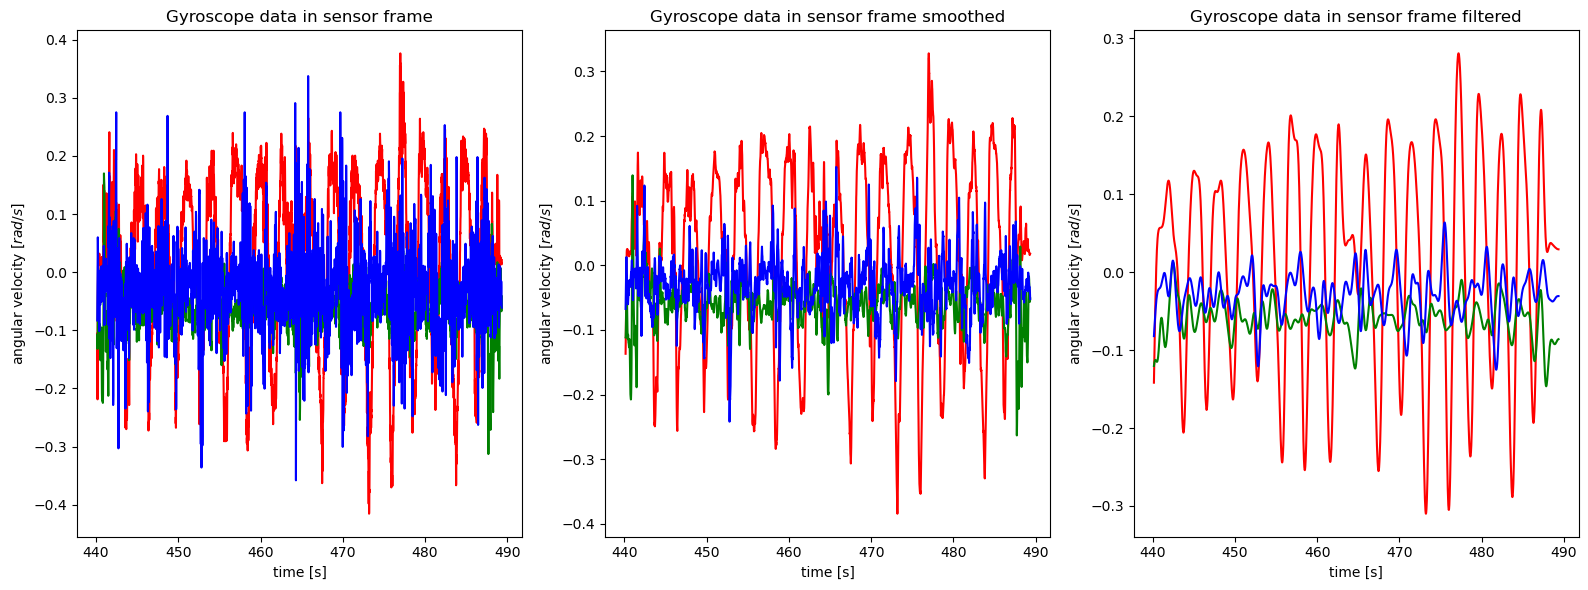

In [12]:
_, axes = plt.subplots(1, 3, figsize=(16, 6))

# Plot 1
axes[0].plot(t, g_s[:, 0], c="r")
axes[0].plot(t, g_s[:, 1], c="g")
axes[0].plot(t, g_s[:, 2], c="b")
axes[0].set_xlabel("time [s]")
axes[0].set_ylabel("angular velocity $[rad/s]$")
axes[0].set_title("Gyroscope data in sensor frame")

# Plot 2 
axes[1].plot(t, g_s_smoothed[:, 0], c="r")
axes[1].plot(t, g_s_smoothed[:, 1], c="g")
axes[1].plot(t, g_s_smoothed[:, 2], c="b")
axes[1].set_xlabel("time [s]")
axes[1].set_ylabel("angular velocity $[rad/s]$")
axes[1].set_title("Gyroscope data in sensor frame smoothed")

# Plot 3 
axes[2].plot(t, g_s_filtered[:, 0], c="r")
axes[2].plot(t, g_s_filtered[:, 1], c="g")
axes[2].plot(t, g_s_filtered[:, 2], c="b")
axes[2].set_xlabel("time [s]")
axes[2].set_ylabel("angular velocity $[rad/s]$")
axes[2].set_title("Gyroscope data in sensor frame filtered")

plt.tight_layout()
plt.show()

In [13]:
# use smoothed one, change to raw (just g_s) or to filtered signal (g_s_filtered)
g_s = g_s_smoothed

#### Kalman filter

In [14]:
import numpy as np
from ahrs.filters import EKF
from ahrs.common.orientation import acc2q

ekf = EKF(frame="ENU")            # Assuming sensors have 1000 samples each
q_sn_kalman = np.zeros((n, 4))  # Allocate array for quaternions
q_sn_kalman[0] = acc2q(a_s[0])       # initial guess
for i in range(1, n):
    ekf.Dt = t[i] - t[i - 1] 
    q_sn_kalman[i] = ekf.update(q_sn_kalman[i-1], g_s[i], a_s[i])

#### Madgwick filter

In [15]:
from ahrs.filters import Madgwick
madgwick = Madgwick()
q_sn_madgwick = np.zeros((n, 4))  # Allocate array for quaternions
q_sn_madgwick[0] = acc2q(a_s[0])       # initial guess
for i in range(1, n):
    madgwick.Dt = t[i] - t[i - 1] 
    q_sn_madgwick[i] = madgwick.updateIMU(q_sn_madgwick[i-1], g_s[i], a_s[i])

#### Mahony filter

In [16]:
from ahrs.filters import Mahony
mahony = Mahony()
q_sn_mahony = np.zeros((n, 4))  # Allocate array for quaternions
q_sn_mahony[0] = acc2q(a_s[0])       # initial guess
for i in range(1, n):
    mahony.Dt = t[i] - t[i - 1] 
    q_sn_mahony[i] = mahony.updateIMU(q_sn_mahony[i-1], g_s[i], a_s[i])

In [17]:
def conjugate(q):
    return q * np.array([1.0, -1.0, -1.0, -1.0])[..., :]

def rotation_matrix(q):
    w = q[..., 0]
    x = q[..., 1]
    y = q[..., 2]
    z = q[..., 3]
    R = np.zeros((*q.shape[:-1], 3, 3), dtype=q.dtype)
    R[..., 0, 0] = 1 - 2 * (y * y + z * z)
    R[..., 0, 1] = 2 * (x * y - z * w)
    R[..., 0, 2] = 2 * (x * z + y * w)
    R[..., 1, 0] = 2 * (x * y + z * w)
    R[..., 1, 1] = 1 - 2 * (x * x + z * z)
    R[..., 1, 2] = 2 * (y * z - x * w)
    R[..., 2, 0] = 2 * (x * z - y * w)
    R[..., 2, 1] = 2 * (y * z + x * w)
    R[..., 2, 2] = 1 - 2 * (x * x + y * y)
    return R

In [18]:
# Get associated rotation matrix, with homogeneous coordinate
R_sn_kalman = rotation_matrix(q_sn_kalman)
R_sn_madgwick = rotation_matrix(q_sn_madgwick)
R_sn_mahony = rotation_matrix(q_sn_mahony)


In [19]:
# Get measured acceleration in navigation frame
a_n_kalman = (R_sn_kalman @ a_s[:, :, None]).squeeze(-1)
a_n_madgwick = (R_sn_madgwick @ a_s[:, :, None]).squeeze(-1)
a_n_mahony = (R_sn_mahony @ a_s[:, :, None]).squeeze(-1)

In [20]:
# It seems that our calibration could be better...
kalman_med = np.median(np.sqrt((a_n_kalman ** 2).sum(axis=-1)))
madgwick_med = np.median(np.sqrt((a_n_madgwick ** 2).sum(axis=-1)))
mahony_med = np.median(np.sqrt((a_n_mahony ** 2).sum(axis=-1)))

print("Kalman median: {}, madgwick median: {} and mahony median: {}".format(kalman_med, madgwick_med, mahony_med))

Kalman median: 9.810595793952672, madgwick median: 9.810595793952672 and mahony median: 9.810595793952672


In [21]:
# Let us use this as "Earth gravity"
EARTH_GRAVITY = 9.81 # 10.0

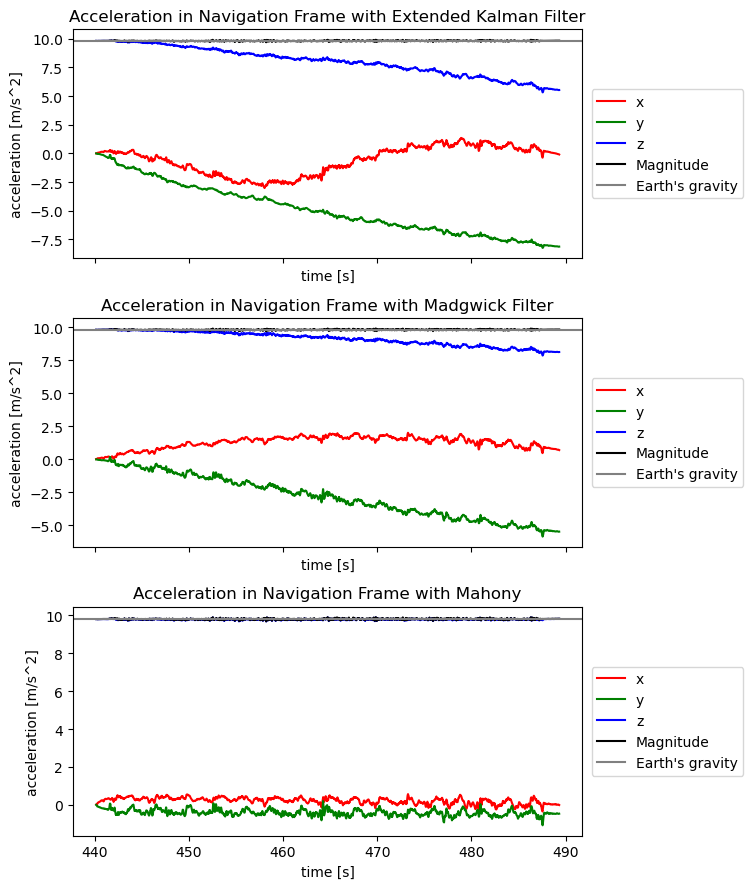

In [22]:
# Create three subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

# Plot for the first subplot
axes[0].plot(t, a_n_kalman[:, 0], c="r", label="x")
axes[0].plot(t, a_n_kalman[:, 1], c="g", label="y")
axes[0].plot(t, a_n_kalman[:, 2], c="b", label="z")
axes[0].plot(t, np.sqrt((a_n_kalman ** 2).sum(axis=-1)), c="k", label="Magnitude")
axes[0].axhline(EARTH_GRAVITY, c="gray", label="Earth's gravity")
axes[0].set_xlabel("time [s]")
axes[0].set_ylabel("acceleration [m/s^2]")
axes[0].set_title("Acceleration in Navigation Frame with Extended Kalman Filter")
axes[0].legend(loc="center right", bbox_to_anchor=(1.33, 0.5))

# Plot for the second subplot
axes[1].plot(t, a_n_madgwick[:, 0], c="r", label="x")
axes[1].plot(t, a_n_madgwick[:, 1], c="g", label="y")
axes[1].plot(t, a_n_madgwick[:, 2], c="b", label="z")
axes[1].plot(t, np.sqrt((a_n_madgwick ** 2).sum(axis=-1)), c="k", label="Magnitude")
axes[1].axhline(EARTH_GRAVITY, c="gray", label="Earth's gravity")
axes[1].set_xlabel("time [s]")
axes[1].set_ylabel("acceleration [m/s^2]")
axes[1].set_title("Acceleration in Navigation Frame with Madgwick Filter")
axes[1].legend(loc="center right", bbox_to_anchor=(1.33, 0.5))

# Plot for the third subplot
axes[2].plot(t, a_n_mahony[:, 0], c="r", label="x")
axes[2].plot(t, a_n_mahony[:, 1], c="g", label="y")
axes[2].plot(t, a_n_mahony[:, 2], c="b", label="z")
axes[2].plot(t, np.sqrt((a_n_mahony ** 2).sum(axis=-1)), c="k", label="Magnitude")
axes[2].axhline(EARTH_GRAVITY, c="gray", label="Earth's gravity")
axes[2].set_xlabel("time [s]")
axes[2].set_ylabel("acceleration [m/s^2]")
axes[2].set_title("Acceleration in Navigation Frame with Mahony")
axes[2].legend(loc="center right", bbox_to_anchor=(1.33, 0.5))

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [23]:
a_n_kalman[:, 2] = a_n_kalman[:, 2] - EARTH_GRAVITY
a_n_madgwick[:, 2] = a_n_madgwick[:, 2] - EARTH_GRAVITY
a_n_mahony[:, 2] = a_n_mahony[:, 2] - EARTH_GRAVITY

In [24]:
@jit(nopython=True)
def integrate_1d(t, dx, x0=0):
    assert t.shape == dx.shape
    (n,) = dx.shape
    x = np.zeros_like(dx)
    x[0] = x0
    for i in range(1, n):
        dt = t[i] - t[i - 1]
        x[i] = (dx[i - 1] + dx[i]) / 2 * dt + x[i - 1]
    return x

def integrate(t, dx):
    _, depth = dx.shape
    x = np.empty_like(dx)
    for d in range(depth):
        x[:, d] = integrate_1d(t, dx[:, d])
    return x

In [25]:
# Integrate acceleration to get velocity
v_n_kalman = integrate(t, a_n_kalman)
v_n_magdwick = integrate(t, a_n_madgwick)
v_n_mahony = integrate(t, a_n_mahony)




In [26]:
# filter velocity

sample_rate = 1.0 / np.mean(np.diff(t))
cutoff = 0.1 
b, a = scipy.signal.butter(6, cutoff, "highpass", fs=sample_rate) 

def highpass_filter(x):
    return scipy.signal.filtfilt(b, a, x, axis=0)


In [27]:
v_n_kalman = highpass_filter(v_n_kalman)
v_n_magdwick = highpass_filter(v_n_magdwick)
v_n_mahony = highpass_filter(v_n_mahony)

In [28]:
# Integrate velocity to get position
p_n_kalman = integrate(t, v_n_kalman)
p_n_madgwick = integrate(t, v_n_magdwick)
p_n_mahony = integrate(t, v_n_mahony)


#### Without filtering the postional data

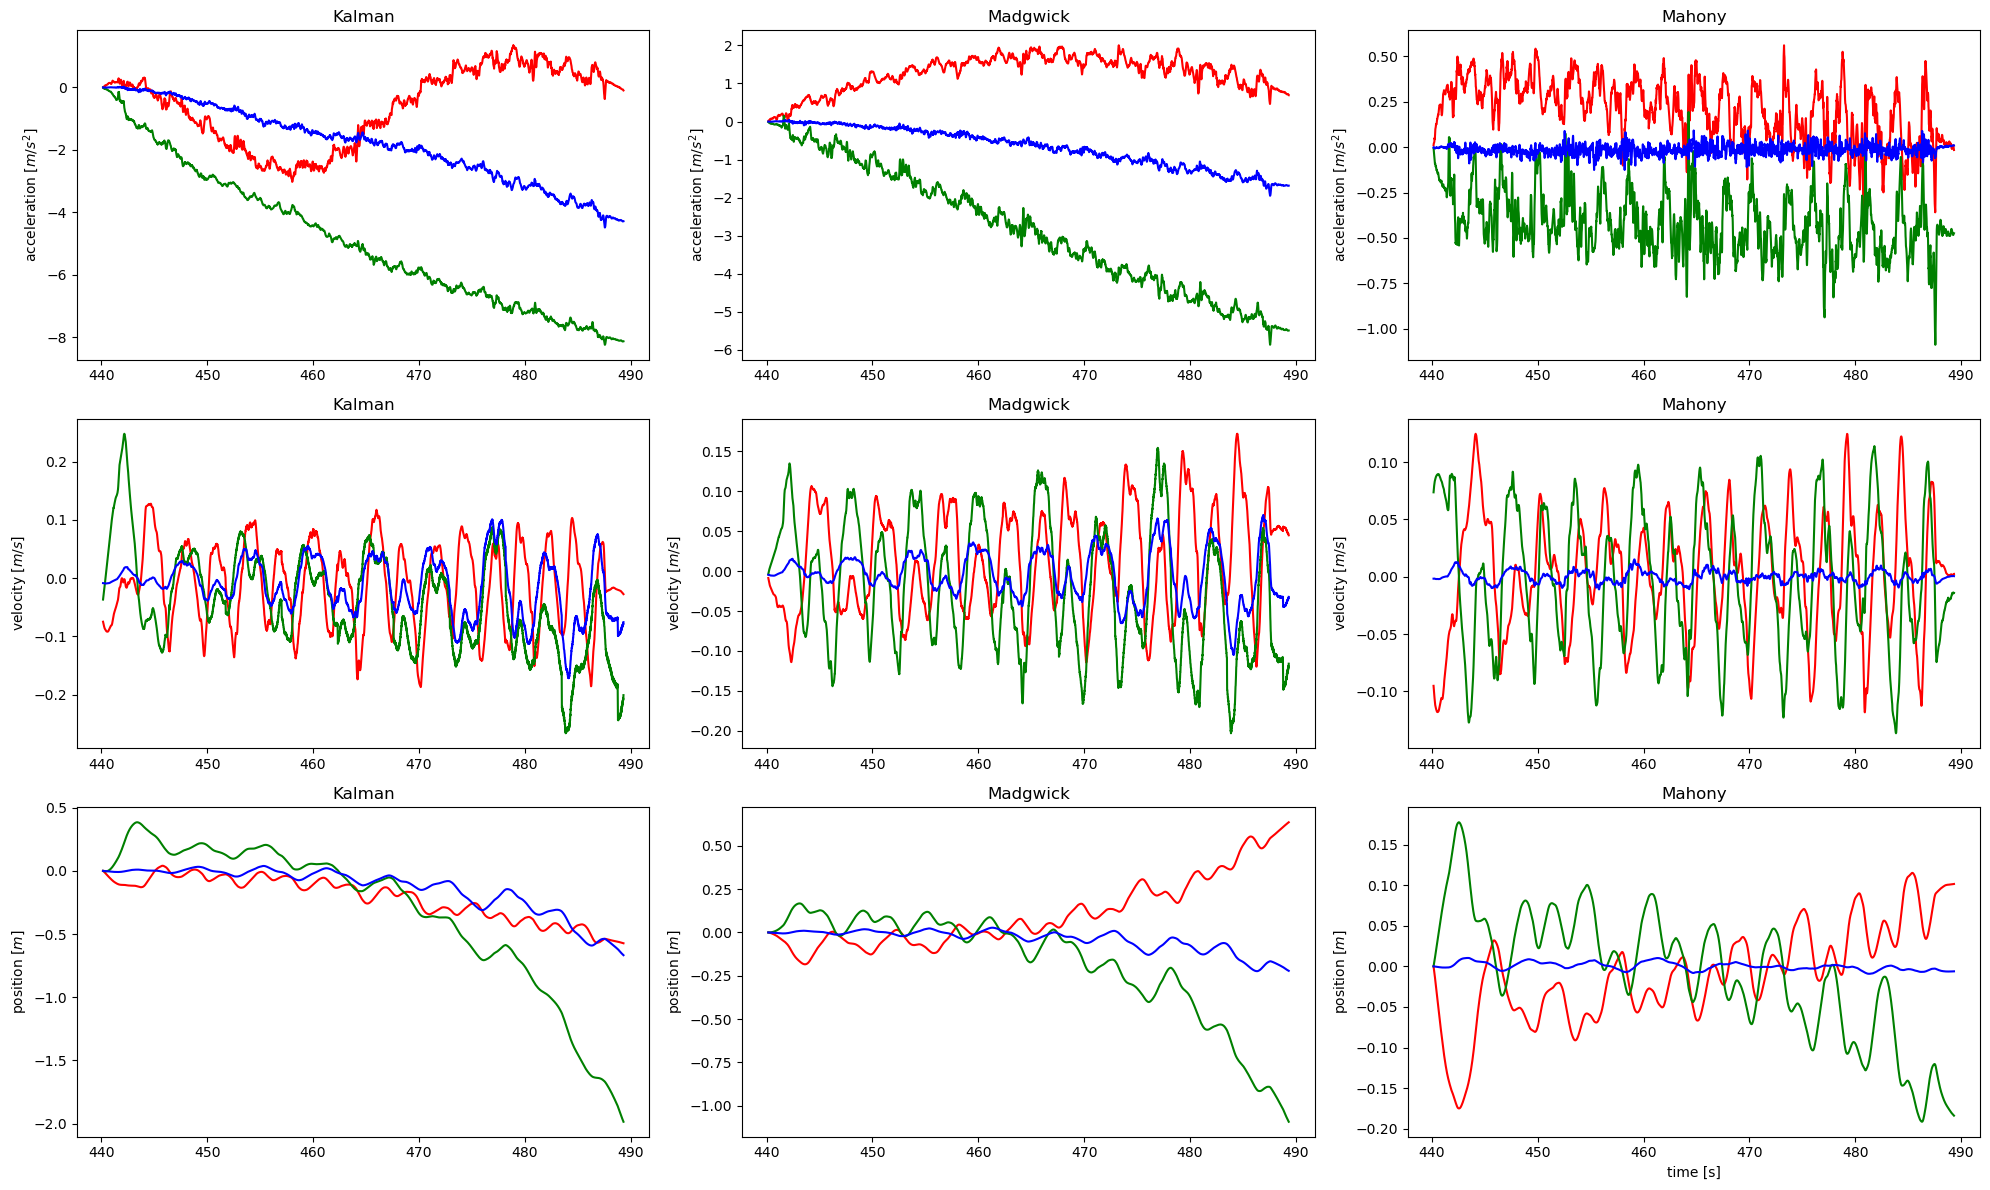

In [29]:
fig = plt.figure(figsize=(20, 12))

# Create the first set of subplots (acceleration)
axes1 = fig.add_subplot(331)
axes1.plot(t, a_n_kalman[:, 0], c="r")
axes1.plot(t, a_n_kalman[:, 1], c="g")
axes1.plot(t, a_n_kalman[:, 2], c="b")
axes1.set_ylabel("acceleration $[m/s^2]$")
axes1.set_title("Kalman")

axes2 = fig.add_subplot(332)
axes2.plot(t, a_n_madgwick[:, 0], c="r")
axes2.plot(t, a_n_madgwick[:, 1], c="g")
axes2.plot(t, a_n_madgwick[:, 2], c="b")
axes2.set_ylabel("acceleration $[m/s^2]$")
axes2.set_title("Madgwick")

axes3 = fig.add_subplot(333)
axes3.plot(t, a_n_mahony[:, 0], c="r")
axes3.plot(t, a_n_mahony[:, 1], c="g")
axes3.plot(t, a_n_mahony[:, 2], c="b")
axes3.set_ylabel("acceleration $[m/s^2]$")
axes3.set_title("Mahony")

# Create the second set of subplots (velocity)
axes4 = fig.add_subplot(334)
axes4.plot(t, v_n_kalman[:, 0], c="r")
axes4.plot(t, v_n_kalman[:, 1], c="g")
axes4.plot(t, v_n_kalman[:, 2], c="b")
axes4.set_ylabel("velocity $[m/s]$")
axes4.set_title("Kalman")

axes5 = fig.add_subplot(335)
axes5.plot(t, v_n_magdwick[:, 0], c="r")
axes5.plot(t, v_n_magdwick[:, 1], c="g")
axes5.plot(t, v_n_magdwick[:, 2], c="b")
axes5.set_ylabel("velocity $[m/s]$")
axes5.set_title("Madgwick")

axes6 = fig.add_subplot(336)
axes6.plot(t, v_n_mahony[:, 0], c="r")
axes6.plot(t, v_n_mahony[:, 1], c="g")
axes6.plot(t, v_n_mahony[:, 2], c="b")
axes6.set_ylabel("velocity $[m/s]$")
axes6.set_title("Mahony")

# Create the third set of subplots (position)
axes7 = fig.add_subplot(337)
axes7.plot(t, p_n_kalman[:, 0], c="r")
axes7.plot(t, p_n_kalman[:, 1], c="g")
axes7.plot(t, p_n_kalman[:, 2], c="b")
axes7.set_ylabel("position $[m]$")
axes7.set_title("Kalman")

axes8 = fig.add_subplot(338)
axes8.plot(t, p_n_madgwick[:, 0], c="r")
axes8.plot(t, p_n_madgwick[:, 1], c="g")
axes8.plot(t, p_n_madgwick[:, 2], c="b")
axes8.set_ylabel("position $[m]$")
axes8.set_title("Madgwick")

axes9 = fig.add_subplot(339)
axes9.plot(t, p_n_mahony[:, 0], c="r")
axes9.plot(t, p_n_mahony[:, 1], c="g")
axes9.plot(t, p_n_mahony[:, 2], c="b")
axes9.set_xlabel("time [s]")
axes9.set_ylabel("position $[m]$")
axes9.set_title("Mahony")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

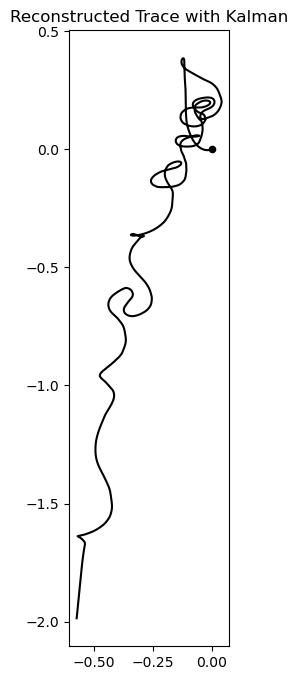

In [30]:
# Show position in horizontal plane
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(p_n_kalman[:, 0], p_n_kalman[:, 1], c="k")
ax.scatter(p_n_kalman[0, 0], p_n_kalman[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.title("Reconstructed Trace with Kalman")
plt.show()

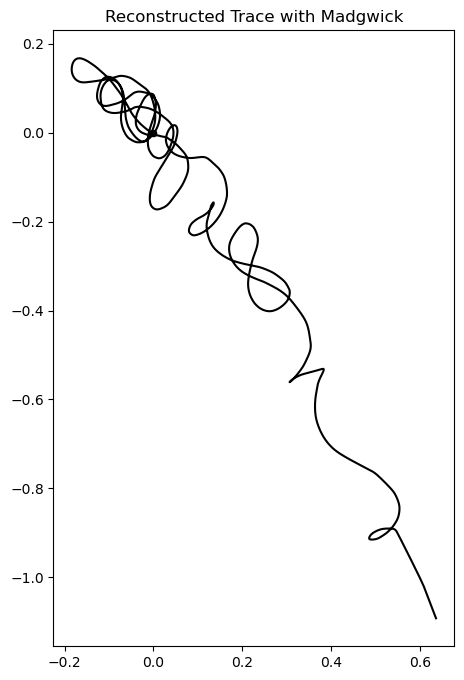

In [31]:
# Show position in horizontal plane
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(p_n_madgwick[:, 0], p_n_madgwick[:, 1], c="k")
ax.scatter(p_n_madgwick[0, 0], p_n_madgwick[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.title("Reconstructed Trace with Madgwick")
plt.show()

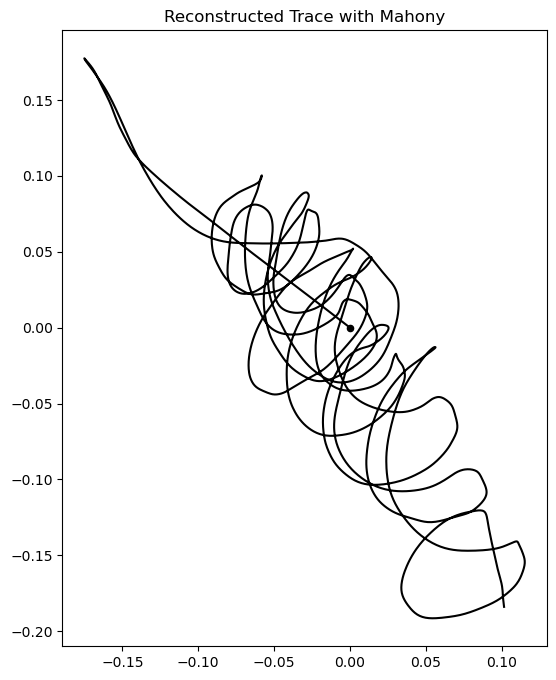

In [32]:
# Show position in horizontal plane
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(p_n_mahony[:, 0], p_n_mahony[:, 1], c="k")
ax.scatter(p_n_mahony[0, 0], p_n_mahony[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.title("Reconstructed Trace with Mahony")
plt.show()

#### With filtering the positional data

In [33]:
# filter position
# filter positional data

sample_rate = 1.0 / np.mean(np.diff(t))
cutoff = 0.1 
b, a = scipy.signal.butter(6, cutoff, "highpass", fs=sample_rate) 

def highpass_filter(x):
    return scipy.signal.filtfilt(b, a, x, axis=0)



p_n_kalman = highpass_filter(p_n_kalman)
p_n_madgwick = highpass_filter(p_n_madgwick)
p_n_mahony = highpass_filter(p_n_mahony)

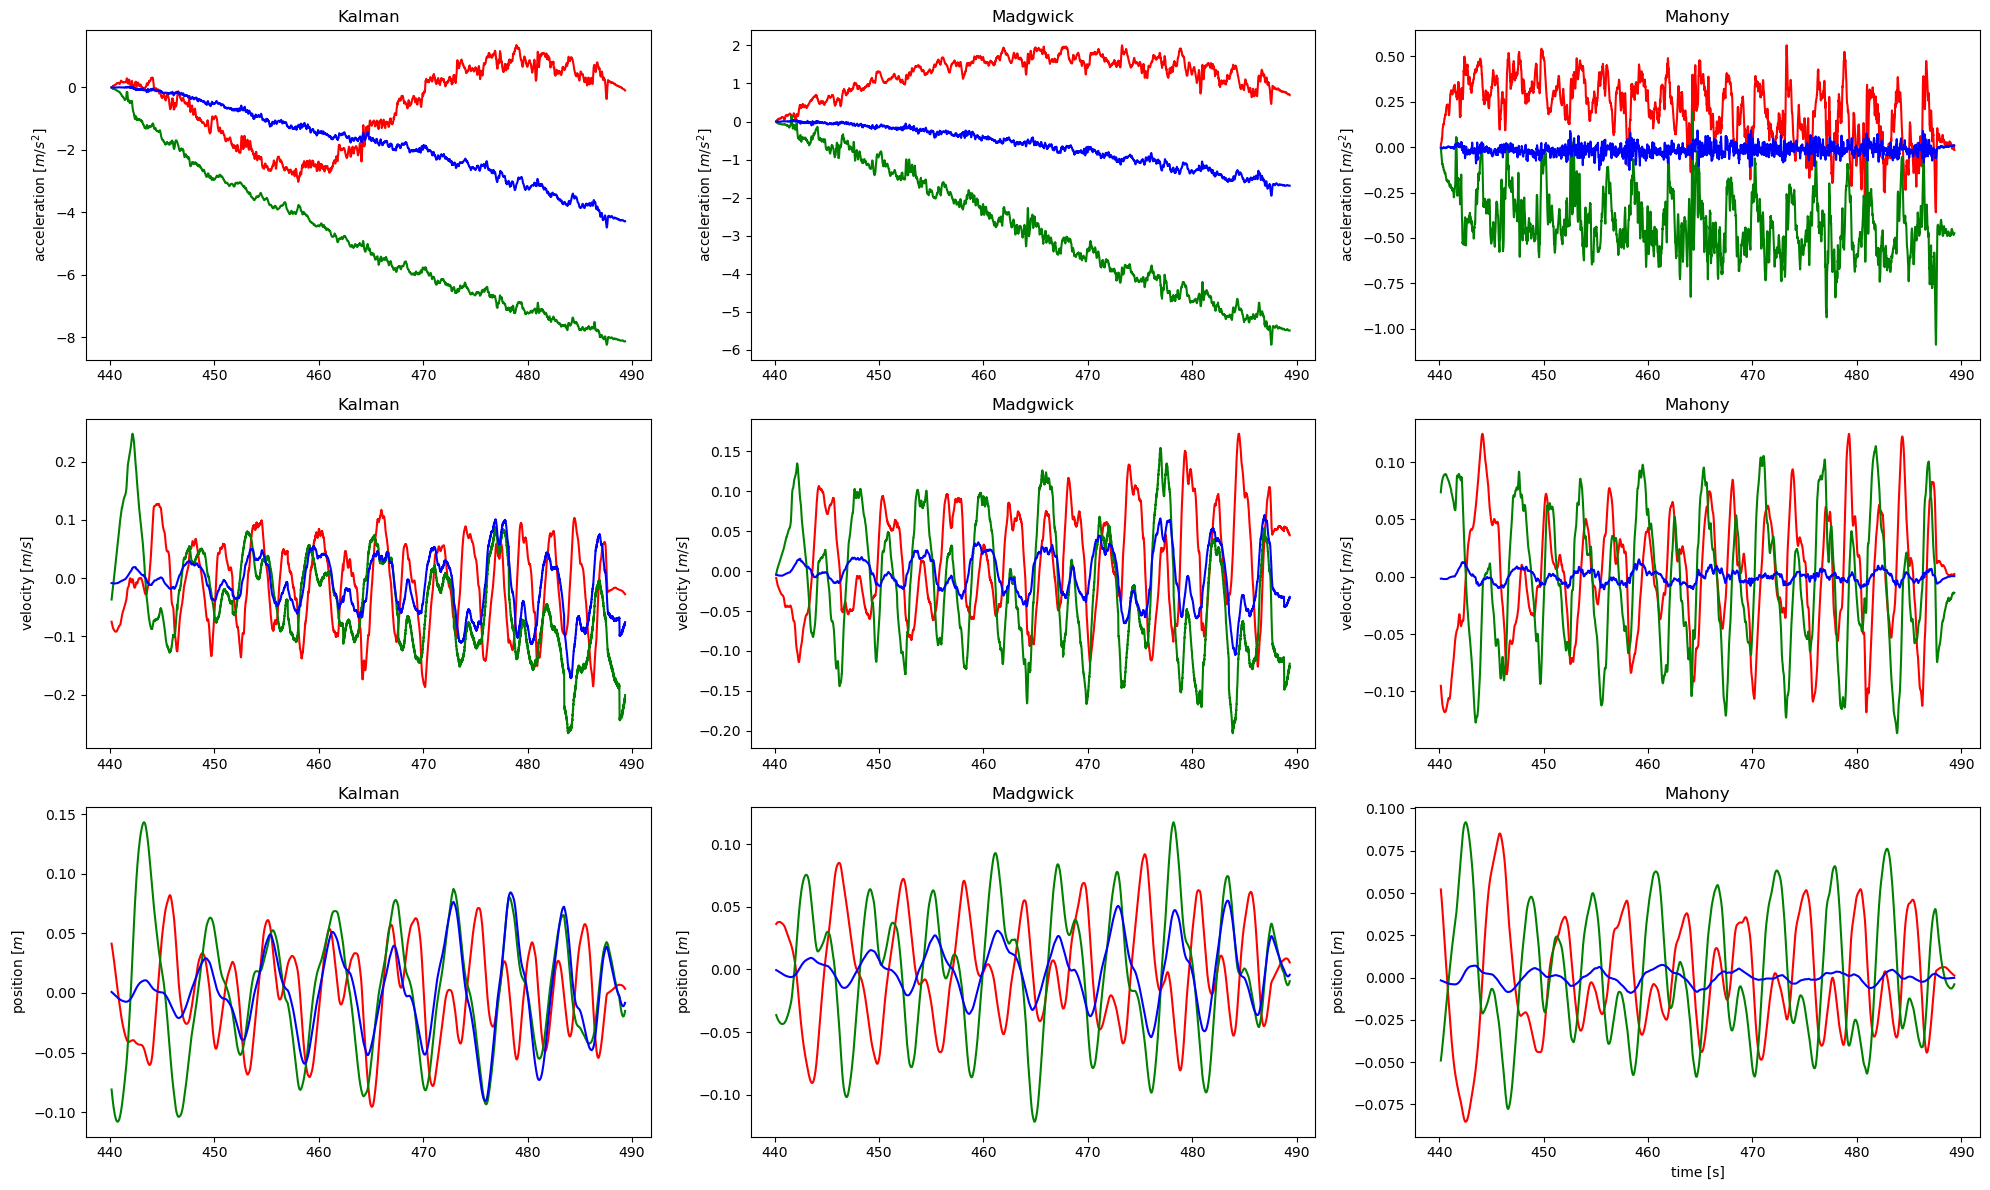

In [34]:
fig = plt.figure(figsize=(20, 12))

# Create the first set of subplots (acceleration)
axes1 = fig.add_subplot(331)
axes1.plot(t, a_n_kalman[:, 0], c="r")
axes1.plot(t, a_n_kalman[:, 1], c="g")
axes1.plot(t, a_n_kalman[:, 2], c="b")
axes1.set_ylabel("acceleration $[m/s^2]$")
axes1.set_title("Kalman")

axes2 = fig.add_subplot(332)
axes2.plot(t, a_n_madgwick[:, 0], c="r")
axes2.plot(t, a_n_madgwick[:, 1], c="g")
axes2.plot(t, a_n_madgwick[:, 2], c="b")
axes2.set_ylabel("acceleration $[m/s^2]$")
axes2.set_title("Madgwick")

axes3 = fig.add_subplot(333)
axes3.plot(t, a_n_mahony[:, 0], c="r")
axes3.plot(t, a_n_mahony[:, 1], c="g")
axes3.plot(t, a_n_mahony[:, 2], c="b")
axes3.set_ylabel("acceleration $[m/s^2]$")
axes3.set_title("Mahony")

# Create the second set of subplots (velocity)
axes4 = fig.add_subplot(334)
axes4.plot(t, v_n_kalman[:, 0], c="r")
axes4.plot(t, v_n_kalman[:, 1], c="g")
axes4.plot(t, v_n_kalman[:, 2], c="b")
axes4.set_ylabel("velocity $[m/s]$")
axes4.set_title("Kalman")

axes5 = fig.add_subplot(335)
axes5.plot(t, v_n_magdwick[:, 0], c="r")
axes5.plot(t, v_n_magdwick[:, 1], c="g")
axes5.plot(t, v_n_magdwick[:, 2], c="b")
axes5.set_ylabel("velocity $[m/s]$")
axes5.set_title("Madgwick")

axes6 = fig.add_subplot(336)
axes6.plot(t, v_n_mahony[:, 0], c="r")
axes6.plot(t, v_n_mahony[:, 1], c="g")
axes6.plot(t, v_n_mahony[:, 2], c="b")
axes6.set_ylabel("velocity $[m/s]$")
axes6.set_title("Mahony")

# Create the third set of subplots (position)
axes7 = fig.add_subplot(337)
axes7.plot(t, p_n_kalman[:, 0], c="r")
axes7.plot(t, p_n_kalman[:, 1], c="g")
axes7.plot(t, p_n_kalman[:, 2], c="b")
axes7.set_ylabel("position $[m]$")
axes7.set_title("Kalman")

axes8 = fig.add_subplot(338)
axes8.plot(t, p_n_madgwick[:, 0], c="r")
axes8.plot(t, p_n_madgwick[:, 1], c="g")
axes8.plot(t, p_n_madgwick[:, 2], c="b")
axes8.set_ylabel("position $[m]$")
axes8.set_title("Madgwick")

axes9 = fig.add_subplot(339)
axes9.plot(t, p_n_mahony[:, 0], c="r")
axes9.plot(t, p_n_mahony[:, 1], c="g")
axes9.plot(t, p_n_mahony[:, 2], c="b")
axes9.set_xlabel("time [s]")
axes9.set_ylabel("position $[m]$")
axes9.set_title("Mahony")

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

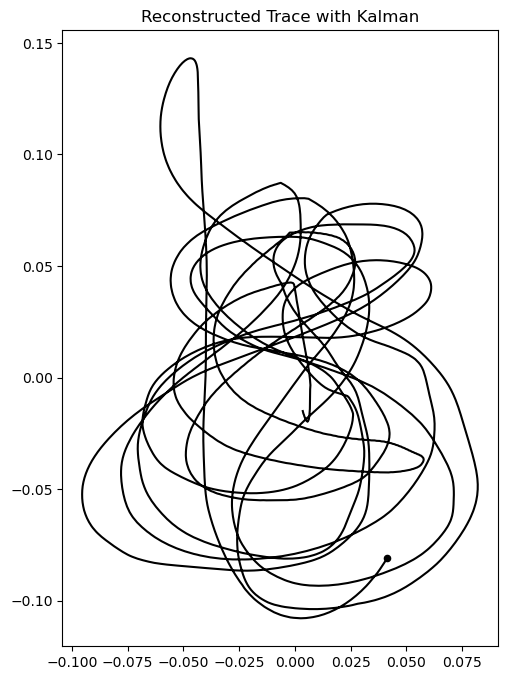

In [35]:
# Show position in horizontal plane
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(p_n_kalman[:, 0], p_n_kalman[:, 1], c="k")
ax.scatter(p_n_kalman[0, 0], p_n_kalman[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.title("Reconstructed Trace with Kalman")
plt.show()

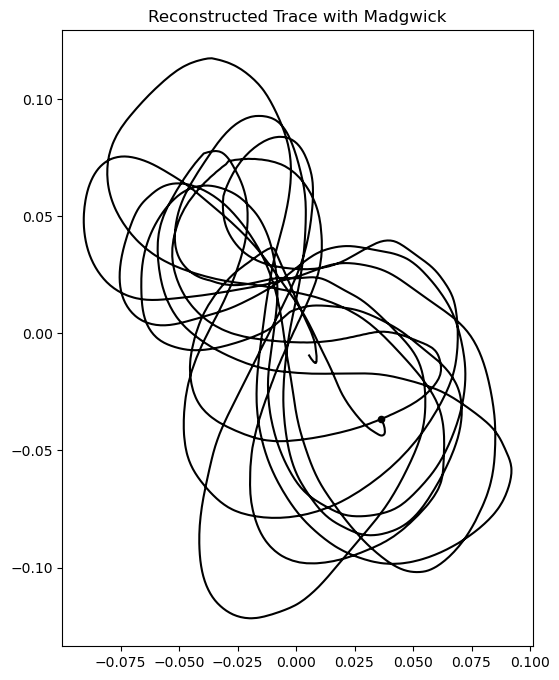

In [36]:
# Show position in horizontal plane
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(p_n_madgwick[:, 0], p_n_madgwick[:, 1], c="k")
ax.scatter(p_n_madgwick[0, 0], p_n_madgwick[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.title("Reconstructed Trace with Madgwick")
plt.show()

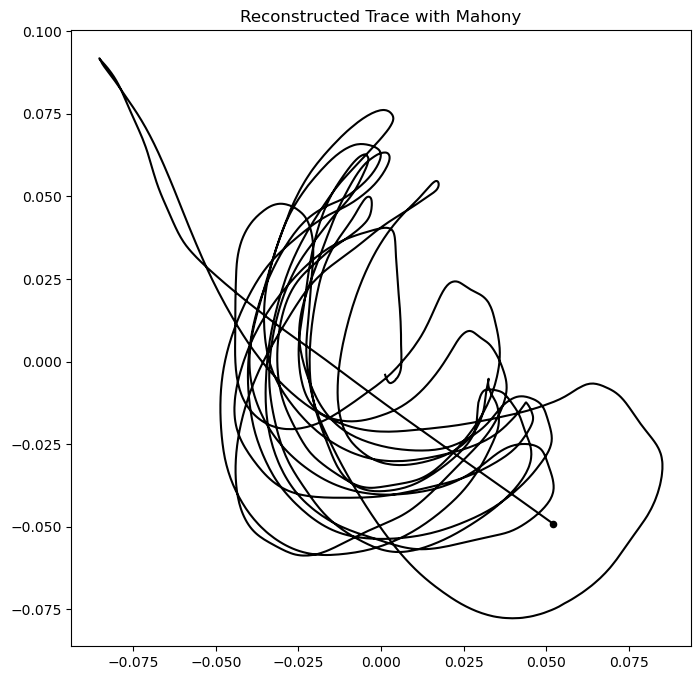

In [37]:
# Show position in horizontal plane
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(p_n_mahony[:, 0], p_n_mahony[:, 1], c="k")
ax.scatter(p_n_mahony[0, 0], p_n_mahony[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.title("Reconstructed Trace with Mahony")
plt.show()